In [1]:
# BibliotecaComunitaria_Analisis.ipynb

# ---
# title: "Análisis Exploratorio de Bibliotecas Comunitarias"
# author: "Luis Eduardo Higuera Calderon"
# date: "2024-11-18"
# ---

# Análisis Exploratorio de Bibliotecas Comunitarias de Bogotá

En este cuaderno, realizaremos un análisis exploratorio de las bibliotecas comunitarias de Bogotá utilizando Neo4j y Python. Utilizaremos la clase `Neo4jRepository` para conectarnos a la base de datos y ejecutar consultas que nos permitirán obtener información valiosa sobre:

1. **Distribución geográfica de las bibliotecas**
2. **Presencia en redes sociales**
3. **Tipos de colecciones disponibles**
5. **Uso de tecnología y conectividad**
6. **Servicios ofrecidos por las bibliotecas**

Comencemos importando las librerías necesarias y estableciendo la conexión con Neo4j.



## Configuración Inicial

In [2]:
# Importar las librerías necesarias
from neo4j import GraphDatabase, exceptions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

# Configurar visualizaciones
%matplotlib inline
sns.set(style="whitegrid")

# Importar la clase Neo4jRepository
from etl.graph_db.neo4j_repository import Neo4JRepository
from etl.utils.models import Neo4JConfig 

# Establecer conexión con Neo4j
config = Neo4JConfig()

neo4j_repo = Neo4JRepository(config.uri, config.user, config.password)

2024-11-25 20:33:14,520 - etl.utils.utils - INFO - Neo4jRepository initialized with URI: bolt://localhost:7687


In [3]:
def obtener_distribucion_bibliotecas(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)
    RETURN
        b.id AS id,
        b.nombre AS nombre,
        b.estado AS estado,
        b.fecha_registro AS fecha_registro
    """
    result = tx.run(query)
    return pd.DataFrame([record.data() for record in result])

df_bibliotecas = neo4j_repo.execute_read(obtener_distribucion_bibliotecas)
print("Número de bibliotecas:", df_bibliotecas.shape[0])
df_bibliotecas.head()


Número de bibliotecas: 173


,id,nombre,estado,fecha_registro
0,BCRU002,Biblioteca Comunitaria Popular y Comunitaria W...,,2024-06-26
1,BCRU003,Biblioteca Comunitaria Raíz de Barro,activa,2024-06-26
2,BCRU004,Biblioteca Comunitaria Vidal Cantor,,2024-06-26
3,BCRU005,Biblioteca Comunitaria CDS Samore,,2024-06-26
4,BCRU006,Biblioteca Comunitaria Parroquial San Judas Tadeo,,2024-06-26


# 1. Análisis de la Distribución Geográfica de las Bibliotecas
Objetivo: Identificar cuántas bibliotecas comunitarias hay en cada localidad y visualizar su distribución.

In [4]:
def obtener_distribucion_bibliotecas(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)-[:PERTENECE_A]->(l:Localidad)
    RETURN l.nombre AS Localidad, COUNT(b) AS NumeroDeBibliotecas
    ORDER BY NumeroDeBibliotecas DESC
    """
    result = tx.run(query)
    return pd.DataFrame([record.data() for record in result])

# Ejecutar la consulta
df_distribucion = neo4j_repo.execute_read(obtener_distribucion_bibliotecas)

# Corrección de tilde en ciudad bolivar
df_distribucion[df_distribucion["Localidad"]=="Ciudad Bolívar"]["Localidad"] = "Ciudad Bolivar"
# Mostrar los primeros registros
df_distribucion.head()


,Localidad,NumeroDeBibliotecas
0,Ciudad Bolivar,28
1,Kennedy,23
2,Suba,22
3,Usme,16
4,Bosa,12


C:\Users\luise\AppData\Local\Temp\ipykernel_9028\2414530141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distribucion[df_distribucion["Localidad"]=="Ciudad Bolívar"]["Localidad"] = "Ciudad Bolivar"


C:\Users\luise\AppData\Local\Temp\ipykernel_9028\3548496290.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_distribucion, x='NumeroDeBibliotecas', y='Localidad', palette='viridis')


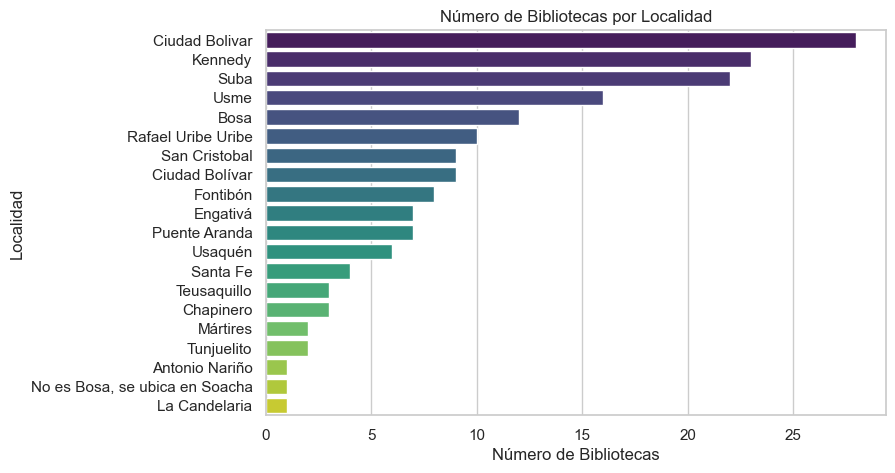

In [19]:
# Gráfico de barras de número de bibliotecas por localidad
plt.figure(figsize=(8, 5))
sns.barplot(data=df_distribucion, x='NumeroDeBibliotecas', y='Localidad', palette='viridis')
plt.title('Número de Bibliotecas por Localidad')
plt.xlabel('Número de Bibliotecas')
plt.ylabel('Localidad')
plt.show()


# 2. Presencia en Redes Sociales
Objetivo: Evaluar la presencia digital de las bibliotecas y en qué plataformas están activas.

In [7]:
def obtener_presencia_redes(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)-[:TIENE_REDES]->(r:Redes_Sociales)
    RETURN 
      COUNT(DISTINCT b) AS TotalBibliotecasConRedes,
      SUM(CASE WHEN r.facebook IS NOT NULL AND r.facebook <> '' THEN 1 ELSE 0 END) AS ConFacebook,
      SUM(CASE WHEN r.instagram IS NOT NULL AND r.instagram <> '' THEN 1 ELSE 0 END) AS ConInstagram,
      SUM(CASE WHEN r.youtube IS NOT NULL AND r.youtube <> '' THEN 1 ELSE 0 END) AS ConYouTube
    """
    result = tx.run(query)
    return result.single().data()

# Ejecutar la consulta
redes_data = neo4j_repo.execute_read(obtener_presencia_redes)

# Convertir a DataFrame para facilitar la visualización
df_redes = pd.DataFrame({
    'Red Social': ['Facebook', 'Instagram', 'YouTube'],
    'Número de Bibliotecas': [redes_data['ConFacebook'], redes_data['ConInstagram'], redes_data['ConYouTube']]
})

df_redes


,Red Social,Número de Bibliotecas
0,Facebook,58
1,Instagram,51
2,YouTube,34


C:\Users\luise\AppData\Local\Temp\ipykernel_9028\3659247587.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


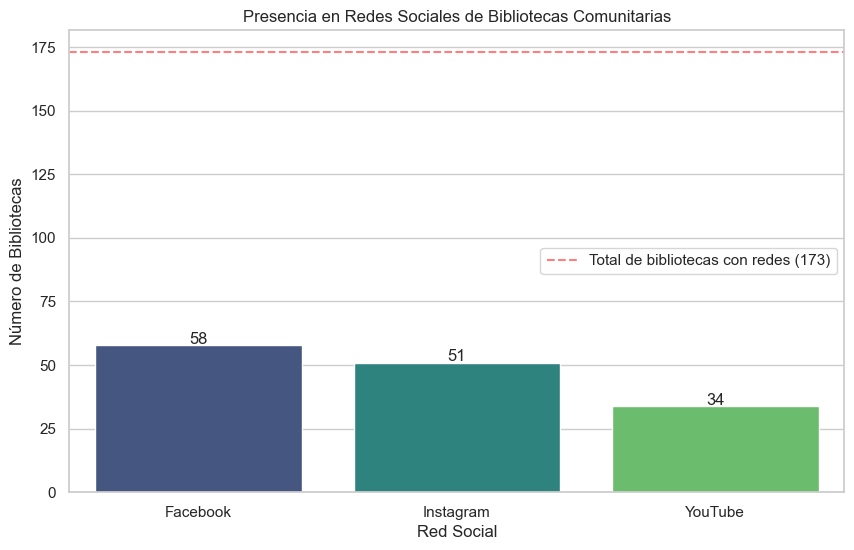

In [8]:
# Crear gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_redes,
    x='Red Social',
    y='Número de Bibliotecas',
    palette='viridis'
)

# Añadir etiquetas con valores exactos sobre cada barra
for i, v in enumerate(df_redes['Número de Bibliotecas']):
    ax.text(i, v + 0.5, str(v), ha='center')

# Personalizar el gráfico
plt.title('Presencia en Redes Sociales de Bibliotecas Comunitarias')
plt.ylabel('Número de Bibliotecas')
plt.xlabel('Red Social')

# Añadir una línea horizontal que muestre el total de bibliotecas
plt.axhline(y=redes_data['TotalBibliotecasConRedes'],
            color='red',
            linestyle='--',
            alpha=0.5,
            label=f"Total de bibliotecas con redes ({redes_data['TotalBibliotecasConRedes']})")

plt.legend()
plt.show()


# 3. Tipos de Colecciones Disponibles
Objetivo: Identificar los tipos de colecciones más comunes entre las bibliotecas.

In [22]:
def obtener_tipos_colecciones(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)-[:CONTIENE_TIPO]->(tc:Tipos_Coleccion)
    RETURN tc.nombre AS TipoDeColeccion, COUNT(b) AS NumeroDeBibliotecas
    ORDER BY NumeroDeBibliotecas DESC
    """
    result = tx.run(query)
    return pd.DataFrame([record.data() for record in result])

# Ejecutar la consulta
df_colecciones = neo4j_repo.execute_read(obtener_tipos_colecciones)

# Mostrar los primeros registros
df_colecciones.head()


,TipoDeColeccion,NumeroDeBibliotecas
0,literatura,47
1,infantiles,42
2,informativos,39
3,texto,37
4,didacticos,34


C:\Users\luise\AppData\Local\Temp\ipykernel_9028\519516401.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_colecciones, x='NumeroDeBibliotecas', y='TipoDeColeccion', palette='viridis')


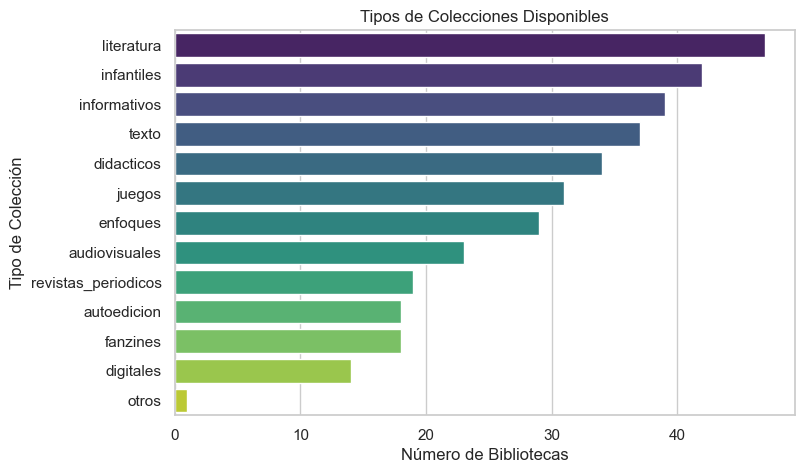

In [24]:
# Gráfico de barras de tipos de colecciones
plt.figure(figsize=(8, 5))
sns.barplot(data=df_colecciones, x='NumeroDeBibliotecas', y='TipoDeColeccion', palette='viridis')
plt.title('Tipos de Colecciones Disponibles')
plt.xlabel('Número de Bibliotecas')
plt.ylabel('Tipo de Colección')
plt.show()


# 5. Uso de Tecnología y Conectividad
Objetivo: Analizar la disponibilidad de tecnología y conectividad en las bibliotecas.

In [9]:
def obtener_uso_tecnologia(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)-[:USA_TECNOLOGIA]->(t:Tecnologia)
    RETURN t.conectividad AS Conectividad, COUNT(b) AS NumeroDeBibliotecas
    """
    result = tx.run(query)
    return pd.DataFrame([record.data() for record in result])

# Ejecutar la consulta
df_tecnologia = neo4j_repo.execute_read(obtener_uso_tecnologia)

# Mostrar los registros
df_tecnologia


,Conectividad,NumeroDeBibliotecas
0,False,148
1,True,27


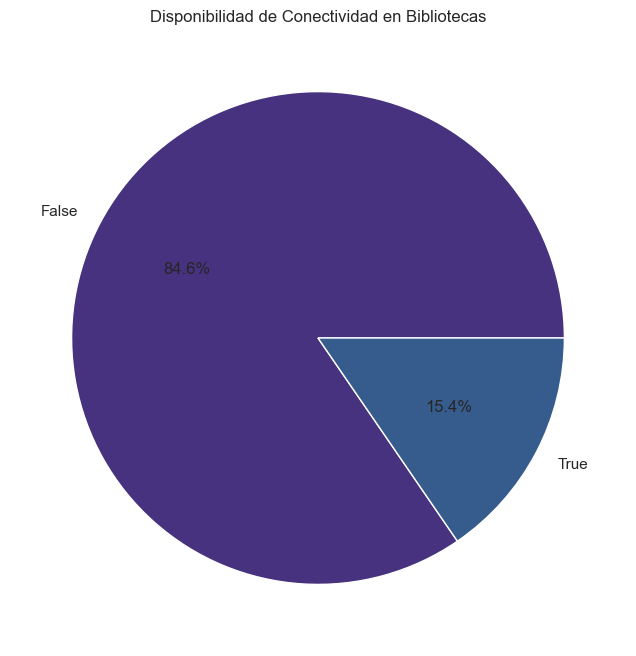

In [10]:
# Gráfico de pastel de conectividad
plt.figure(figsize=(8, 8))
plt.pie(df_tecnologia['NumeroDeBibliotecas'], labels=df_tecnologia['Conectividad'], autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Disponibilidad de Conectividad en Bibliotecas')
plt.show()


# 6. Servicios Ofrecidos por las Bibliotecas
Objetivo: Conocer los servicios más comunes que ofrecen las bibliotecas comunitarias.

In [30]:
def obtener_servicios_ofrecidos(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)-[:OFRECE_SERVICIO]->(s:Tipos_Servicio)
    RETURN s.nombre AS Servicio, COUNT(b) AS NumeroDeBibliotecas
    ORDER BY NumeroDeBibliotecas DESC
    """
    result = tx.run(query)
    return pd.DataFrame([record.data() for record in result])

# Ejecutar la consulta
df_servicios = neo4j_repo.execute_read(obtener_servicios_ofrecidos)

# Mostrar los primeros registros
df_servicios.head()


,Servicio,NumeroDeBibliotecas
0,culturales,44
1,comunitarios,43
2,leo,41
3,consulta,39
4,prestamo_externo,29


C:\Users\luise\AppData\Local\Temp\ipykernel_9028\3289834667.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_servicios, x='NumeroDeBibliotecas', y='Servicio', palette='viridis')


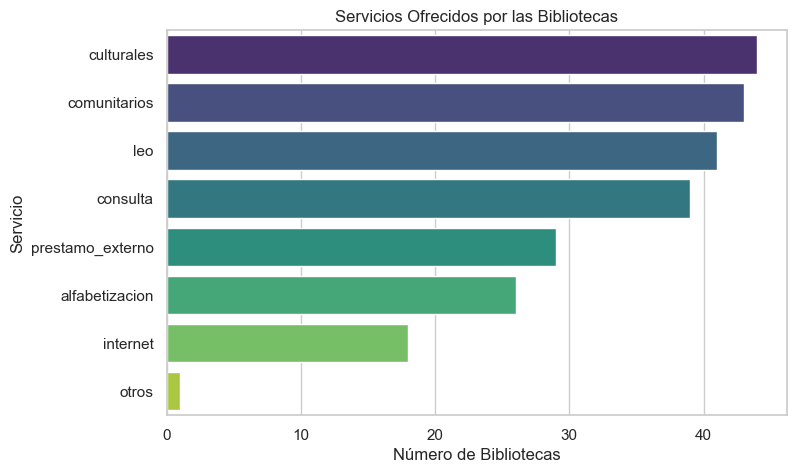

In [31]:
# Gráfico de barras de servicios ofrecidos
plt.figure(figsize=(8, 5))
sns.barplot(data=df_servicios, x='NumeroDeBibliotecas', y='Servicio', palette='viridis')
plt.title('Servicios Ofrecidos por las Bibliotecas')
plt.xlabel('Número de Bibliotecas')
plt.ylabel('Servicio')
plt.show()


# Cierre de la Conexión
Finalmente, cerraremos la conexión con la base de datos.

In [13]:
neo4j_repo.close()

2024-11-18 18:42:01,797 - INFO - Neo4jRepository connection closed


# Nota
Este cuaderno está diseñado para ser ejecutado en un entorno donde la base de datos Neo4j está configurada correctamente y los datos mencionados están cargados en el grafo. Asegúrate de actualizar las credenciales de conexión y verificar que las etiquetas y relaciones en las consultas coincidan con tu modelo de datos.